## CartPole with Q-learning

Q-learning is a off-policy temporal-difference method that uses the following update:
$$Q(S_t, A_t) \gets Q(S_t, A_t) + \alpha \left[ R_{t+1} + \gamma max_a Q(S_t+1, a) - Q(S_t, A_t) \right]$$

where $Q(S_t, A_t)$ is the value of taking action $A_t$ in state $S_t$, $\alpha$ is the step-size (learning rate) and $R_{t+1}$ is the reward received. We update $Q(S_t, A_t)$ using the direct reward received plus the reward we expect to receive in future. The update can be seen as optimistic because we take the maximum expected return.

The objective of the CartPole problem (from OpenAI gym: https://gym.openai.com/envs/CartPole-v0) is to teach the cart to balance a pole by applying a horizontal force to the left or right. An episode ends when the pole tips more than 15 degrees from the vertical or the cart moves more than 2.4 units from the center. In smaller problems like Grid World, a table could be used to store all possible combinations of states and actions. In more complex problems, especially those with continuous states or actions, it is impossible to completely represent all state and action pairs so an approximator (neural network) is used. The input to the neural network is a state and the output is the value of all actions (we can then choose to take the action with the highest value if we're following $\epsilon$-greedy action selection for example).

In [39]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gym
import cntk
from cntk import *
from cntk.layers import *

The Agent class encapsulates all the necessary logic related to action action selection and model training. The network inputs and outputs depend on the environment chosen so it receives their dimensions as arguments to its constructor. I have chosen to use a network with a single hidden layer of 64 neurons and ReLu (REctified Linear Unit) activation. I calculate the loss as the mean of the square difference between the actual outputs and the expected outputs and have chosen to use a learning rate of 0.0025 and stochastic gradient descent for learning.

Once again we are using $\epsilon$-greedy action selection. We generate a random number and if it is below our threshold, $\epsilon$, we pick a random action (explore), otherwise, we use the output of our model (exloit current knowledge) and the action with the highest value is selected (greedy). To see the effects of a constant versus decaying epsilon (value reduces with time), the constructor has a parameter which is a function for updating epsilon based on the number of completed episodes.

The evaluate function allows us to evaluate the average performance of the agent over a given number of episodes.

In [40]:
class Agent:
    def __init__(self, state_dim, action_dim, learning_rate, epsilon_fn):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.learning_rate = learning_rate
        self.epsilon_fn = epsilon_fn
        self.epsilon = 1
        
        # Create the neural network
        self.state_var = input(state_dim, np.float32)
        self.action_var = input(action_dim, np.float32)
        
        self.model = Sequential([
            Dense(64, activation=relu),
            Dense(action_dim)
        ])(self.state_var)
        
        loss = reduce_mean(square(self.model - self.action_var), axis=0)
        lr_schedule = learning_rate_schedule(self.learning_rate, UnitType.sample)
        learner = sgd(self.model.parameters, lr_schedule)
        self.trainer = Trainer(self.model, loss, learner)
    
    def predict(self, state):
        """
        Feeds a state through our model to obtain the values of each action
        """
        return self.model.eval(state)[0]
    
    def act(self, state):
        """
        Selects an action using the epoch-greedy approach
        """
        prob = np.random.randn(1)
        if prob > self.epsilon:
            # exploit (greedy)
            return np.argmax(self.predict(state))
        else:
            # explore (random action)
            return np.random.randint(0, self.action_dim)
        
    def update_epsilon(self, episode):
        """
        Update the value of epsilon using the provided update function
        """
        self.epsilon = self.epsilon_fn(episode)
        
    def train(self, x, y):
        """
        Performs a single gradient descent step using the provided state and target
        """
        self.trainer.train_minibatch({self.state_var: x, self.action_var: y})
        
    def evaluate(self, env, n):
        """
        Computes the average performance of the trained model over n episodes
        """
        episode = 0
        rewards = 0
        while episode < n:
            s = env.reset()
            done = False
            while not done:
                a = np.argmax(self.predict(s.astype(np.float32)))
                s, r, done, info = env.step(a)
                rewards += r
            episode += 1
            
        return rewards / float(n)

For each step of an episode, we select an action (using $\epsilon$-greedy action selection) and then execute it yielding the next state and reward as well as a boolean indicating if the next state is terminal. We then calculate the expected return as the sum of the received reward plus the discounted future reward (0 if terminal). The current state serves as our input and the expected return serves as the label (truth value) for the neural network. Finally, I store the reward for each episode so we can monitor the progress.

In [41]:
def train(env, agent, episodes, gamma):
    """
    param env: The gym environment to train with
    param agent: The agent to train
    param episodes: The number of episodes to train for
    param gamma: The discount factor
    """
    episode = 0
    rewards = 0
    log_freq = 200
    episode_rewards = []
    s = env.reset().astype(np.float32)
    
    while episode < episodes:
        # Select an action using policy derived from Q (e-greedy)
        a = agent.act(s)
        
        # Take action and observe the next state and reward
        s_, r, done, info = env.step(a)
        s_ = s_.astype(np.float32)
        
        # Compute target, y_i
        y = agent.predict(s)
        if done:
            y[a] = r
        else:
            y[a] = r + gamma * np.amax(agent.predict(s_))
        
        # Train using state and computed target
        agent.train(s, y)
        
        s = s_
        rewards += r
        
        if done:
            # Episode over, reset environment
            episode_rewards.append(rewards)
            rewards = 0
            
            episode += 1
            agent.update_epsilon(episode)
            s = env.reset().astype(np.float32)
            
            if episode % log_freq == 0:
                ave = sum(episode_rewards[(episode - log_freq):]) / float(log_freq)
                print('Episode = {}, Average rewards = {}'.format(episode, ave))
                
    return episode_rewards
            

I have decided to train for 10k episodes using a discount factor of 0.60 - for all states before the terminal state, we receive a reward of 1, so I chose to factor later rewards less. For the constant $\epsilon$ agent, I've chosen to use $\epsilon = 0.1$ and for the other, $\epsilon$ decays from a value of 1 to a minimum of 0.05 by the 8000th episode.

In [42]:
# Fixed value epsilon
def constant_epsilon(episode):
    return 0.1

In [43]:
# epsilon starts with 1 and decays to a minimum of 0.05
# decay factor was chosen such that the value of epsilon is 0.05 by episode 8000
def decaying_epsilon(episode):
    return max(math.exp(-3.74e-4 * episode), 0.05)

In [44]:
gamma = 0.60
learning_rate = 0.00025
episodes = 10000

In [45]:
env = gym.make('CartPole-v0')
state_dim = env.observation_space.shape
action_dim = env.action_space.n

[2017-04-21 13:13:56,346] Making new env: CartPole-v0


In [46]:
agent1 = Agent(state_dim, action_dim, learning_rate, constant_epsilon)
rewards1 = train(env, agent1, episodes, gamma)

Episode = 200, Average rewards = 42.31
Episode = 400, Average rewards = 18.215
Episode = 600, Average rewards = 14.0
Episode = 800, Average rewards = 14.665
Episode = 1000, Average rewards = 14.875
Episode = 1200, Average rewards = 14.17
Episode = 1400, Average rewards = 14.715
Episode = 1600, Average rewards = 15.635
Episode = 1800, Average rewards = 15.285
Episode = 2000, Average rewards = 18.925
Episode = 2200, Average rewards = 38.125
Episode = 2400, Average rewards = 28.425
Episode = 2600, Average rewards = 19.205
Episode = 2800, Average rewards = 17.465
Episode = 3000, Average rewards = 17.445
Episode = 3200, Average rewards = 26.23
Episode = 3400, Average rewards = 31.22
Episode = 3600, Average rewards = 35.81
Episode = 3800, Average rewards = 32.67
Episode = 4000, Average rewards = 35.815
Episode = 4200, Average rewards = 35.175
Episode = 4400, Average rewards = 40.88
Episode = 4600, Average rewards = 43.035
Episode = 4800, Average rewards = 45.36
Episode = 5000, Average reward

In [47]:
agent2 = Agent(state_dim, action_dim, learning_rate, decaying_epsilon)
rewards2 = train(env, agent2, episodes, gamma)

Episode = 200, Average rewards = 19.58
Episode = 400, Average rewards = 18.885
Episode = 600, Average rewards = 20.27
Episode = 800, Average rewards = 19.32
Episode = 1000, Average rewards = 19.58
Episode = 1200, Average rewards = 18.38
Episode = 1400, Average rewards = 17.91
Episode = 1600, Average rewards = 19.915
Episode = 1800, Average rewards = 20.0
Episode = 2000, Average rewards = 23.675
Episode = 2200, Average rewards = 25.63
Episode = 2400, Average rewards = 25.895
Episode = 2600, Average rewards = 27.605
Episode = 2800, Average rewards = 27.065
Episode = 3000, Average rewards = 28.775
Episode = 3200, Average rewards = 29.995
Episode = 3400, Average rewards = 30.555
Episode = 3600, Average rewards = 32.385
Episode = 3800, Average rewards = 36.515
Episode = 4000, Average rewards = 33.98
Episode = 4200, Average rewards = 34.515
Episode = 4400, Average rewards = 41.065
Episode = 4600, Average rewards = 40.375
Episode = 4800, Average rewards = 43.11
Episode = 5000, Average rewards

For visual comparison of learning with time, I have plotted the moving averages of the received rewards below:

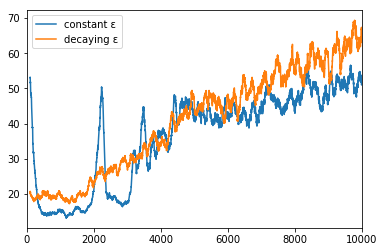

In [52]:
pd.Series(rewards1).rolling(window=100).mean().plot(label='constant \u03b5')
pd.Series(rewards2).rolling(window=100).mean().plot(label='decaying \u03b5')
plt.legend()
plt.show()

Here, I evaluate the performance of the trained agents over 100 episodes:

In [49]:
eval_episodes = 100
ave_constant = agent1.evaluate(env, eval_episodes)
ave_decaying = agent2.evaluate(env, eval_episodes)

print('Average (with constant \u03b5) = {}'.format(ave_constant))
print('Average (with decaying \u03b5) = {}'.format(ave_decaying))

Average (with constant ε) = 87.41
Average (with decaying ε) = 138.36


## Conclusion
From the plot of average reward for each model during training, we can see that learning is better with a decaying $\epsilon$ as opposed to a constant small epsilon. The results of evaluation over 100 episodes also supports this point. In practice, epsilon is usually annealed to a small value to simulate how we learn - a lot of exploration at the start but less and less as our knowledge improves.

Here I run and render an episode using the better model:

In [50]:
s = env.reset()
done = False
while not done:
    env.render()
    a = np.argmax(agent2.predict(s.astype(np.float32)))
    s, r, done, info = env.step(a)
    
env.close()

Obviously there is still room for improvement. You can play around with the number of layers in the network (as well as the number of neurons in each layer), a different min value for epsilon (in the exponentially decaying version), a different learner (as opposed to stochastic gradient descent), different learning rate, gamma, train for longer and so on...

## References
1. Richard S. Sutton, Andrew G. Barto (1998). Reinforcement Learning: An Introduction. MIT Press.